- 1 , 在半径R=1圆内分布随机产生 $8,16,32,64$ 个粒子, 每个粒子质量 $m=1$, 它们之间两两存在 相互作用力 $F=1 / r^{2} \times 10^{-2}$ ，其中r为两个粒子之间 距离。与边界的作用力是 $100^{*} \exp (-\mathrm{d}), \mathrm{d}$ 为粒子 到边界的最短距离。空间格点数为 $1000 \times 1000$, 选择合适的时间步长, 模拟得到稳定态的过程并 作出最后分布图。
- 2 , 分析100次的模拟结果。
- 3, 给出上例并行算法的思路和电路图。

取速度跟相互作用力成正比

In [29]:
import numpy as np
from numba import njit,jit,prange
import numba
import matplotlib.pyplot as plt

numba.config.NUMBA_DEFAULT_NUM_THREADS=4

In [30]:
@njit
def get_r(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

@njit
def difference_iteration(x,y,dx,dt):
    nn = x.shape[0]
    tn = x.shape[1]
    
    for k in range(0,tn-1):
        for i in range(0,nn):
            # 计算边界力
            rk = np.sqrt(x[i,k]**2+y[i,k]**2)
            d = 1.- rk
            if(x[i,k]==0):
                fdx = 0.
                fdy = 0.
            else:
                fdx = -100*np.exp(-d)*x[i,k]/rk
                fdy = -100*np.exp(-d)*y[i,k]/rk
                
            # 计算相互作用力
            frx = 0.
            fry = 0.
            for n in range(0,nn):
                if(n==i):continue
                # x分量
                rkn = get_r(x[i,k],y[i,k],x[n,k],y[n,k])
                frx += 1/(rkn**2)*10**(-2)*(x[i,k] - x[n,k])/rkn
                fry += 1/(rkn**2)*10**(-2)*(y[i,k] - y[n,k])/rkn
            # 运动方程
            x[i,k+1] = dt*(fdx+frx)+x[i,k]
            y[i,k+1] = dt*(fdy+fry)+y[i,k]
    
    return x,y
@njit
def init_xy(shape, nn, tn):
    x = np.zeros_like(shape)
    y = np.zeros_like(shape)

    for n in range(nn):
        r = np.random.rand()
        theta = np.random.rand()*2*np.pi
        x[n,0] = r*np.cos(theta)
        y[n,0] = r*np.sin(theta)
    
    return x,y

#此处并行提速2.76/1.0
@njit(nogil=True, parallel=True)
def repeat(list_x, list_y, nn, tn, dx, dt):
    for i in prange(100):
        x,y= init_xy(list_x[0,:,:], nn, tn)
        list_x[i],list_y[i] = difference_iteration(x,y,dx,dt)
    
    return list_x, list_y

In [31]:
def evolute(nn,tn):
    dx = 2./1000
    # dt/m <= 1❓
    dt = dx/100
    
    list_x = np.zeros([100, nn, tn])
    list_y = np.zeros([100, nn, tn])
    
    list_x, list_y = repeat(list_x, list_y, nn, tn, dx, dt)
    
    return list_x, list_y


In [32]:
%%time
array_x = []
array_y = []

array_mean_x = []
array_mean_y = []
tn = 1000

nn_list = [8, 16, 32, 64]

for nn in nn_list:
    #索引：迭代次数，粒子编号，时间    
    list_x, list_y =  evolute(nn, tn)

    list_mean_x = np.zeros(100)
    list_mean_y = np.zeros(100)

    for i in range(100):
        list_mean_x[i] = np.mean(list_x[i,:,-1])
        list_mean_y[i] = np.mean(list_y[i,:,-1])
        
    array_x.append(list_x)
    array_y.append(list_y)
    array_mean_x.append(list_mean_x)
    array_mean_y.append(list_mean_y)

Wall time: 7.06 s


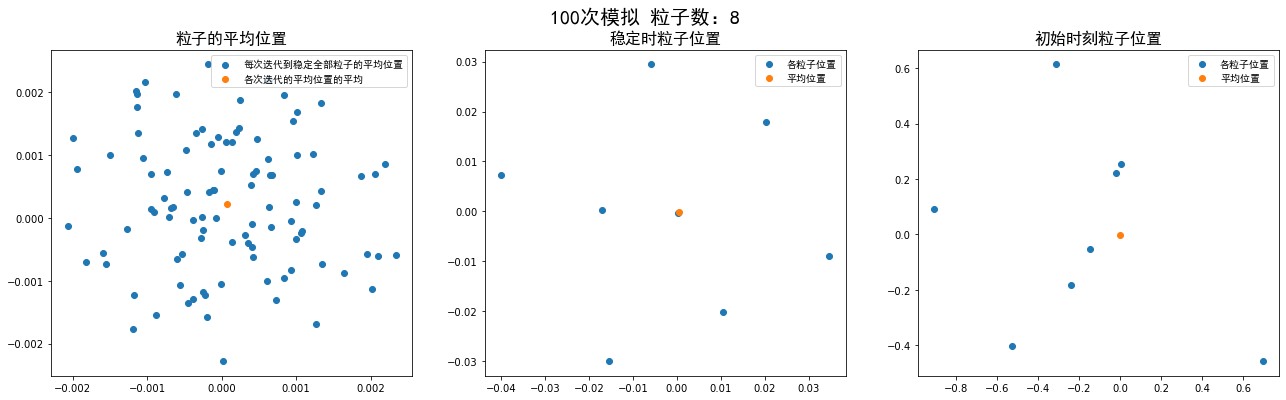

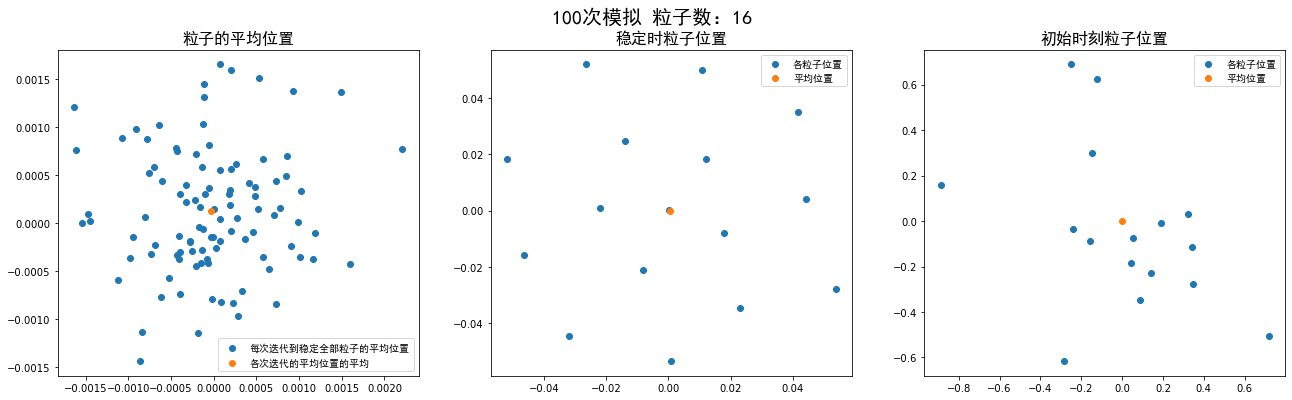

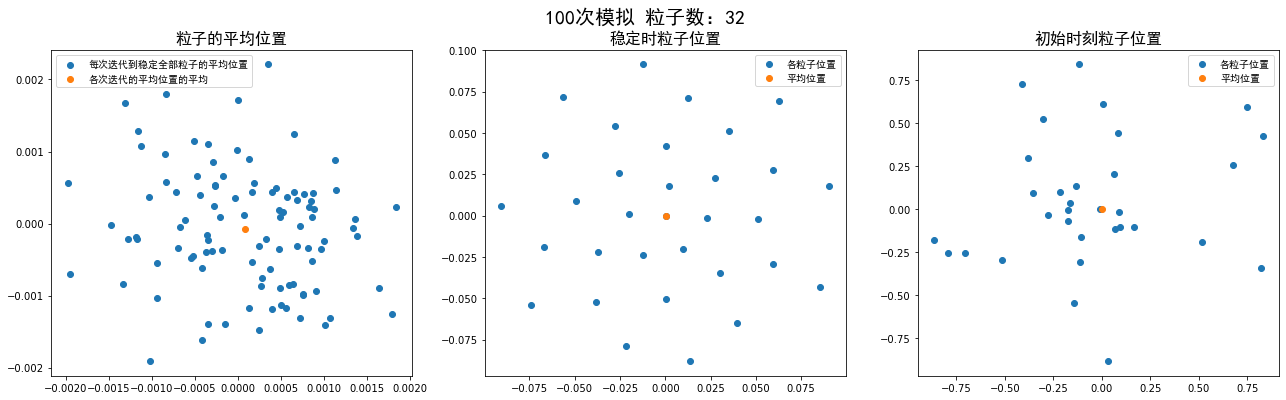

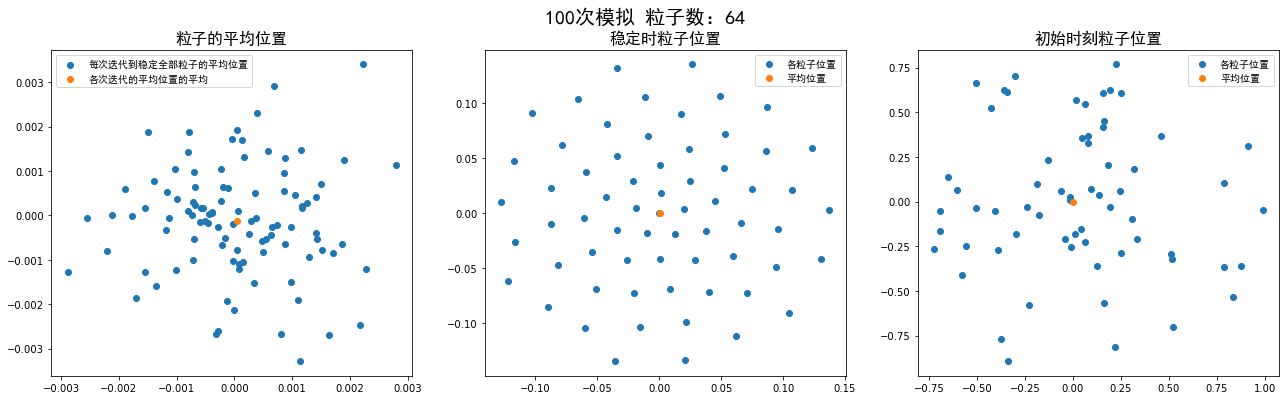

In [39]:
for i, nn in enumerate(nn_list):
    fig=plt.figure(figsize=(22,6))
    fig.suptitle("100次模拟 粒子数：{}".format(nn), fontproperties="SimHei",fontsize=20)

    ax1=fig.add_subplot(131)
    ax1.scatter(array_mean_x[i], array_mean_y[i])
    ax1.scatter(np.mean(array_mean_x[i]), np.mean(array_mean_y[i]))
    ax1.legend(["每次迭代到稳定全部粒子的平均位置","各次迭代的平均位置的平均"],  frameon=True, prop={"family" : "SimHei"})
    # ax没有title方法，要用set_title
    ax1.set_title("粒子的平均位置", fontproperties="SimHei", fontsize=16)

    ax2=fig.add_subplot(132)
    ax2.scatter(array_x[i][0, :, -1], array_y[i][0, :, -1])
    ax2.scatter(array_mean_x[0][-1], array_mean_y[0][-1])
    ax2.legend(["各粒子位置","平均位置"],  frameon=True, prop={"family" : "SimHei"})
    # ax没有title方法，要用set_title
    ax2.set_title("稳定时粒子位置", fontproperties="SimHei", fontsize=16)
    
    ax3=fig.add_subplot(133)
    ax3.scatter(array_x[i][0, :, 0], array_y[i][0, :, 0])
    ax3.scatter(array_mean_x[0][0], array_mean_y[0][0])
    ax3.legend(["各粒子位置","平均位置"],  frameon=True, prop={"family" : "SimHei"})
    # ax没有title方法，要用set_title
    ax3.set_title("初始时刻粒子位置", fontproperties="SimHei", fontsize=16)

    plt.show()

可见粒子平均位置在迭代过程中，基本在原点附近

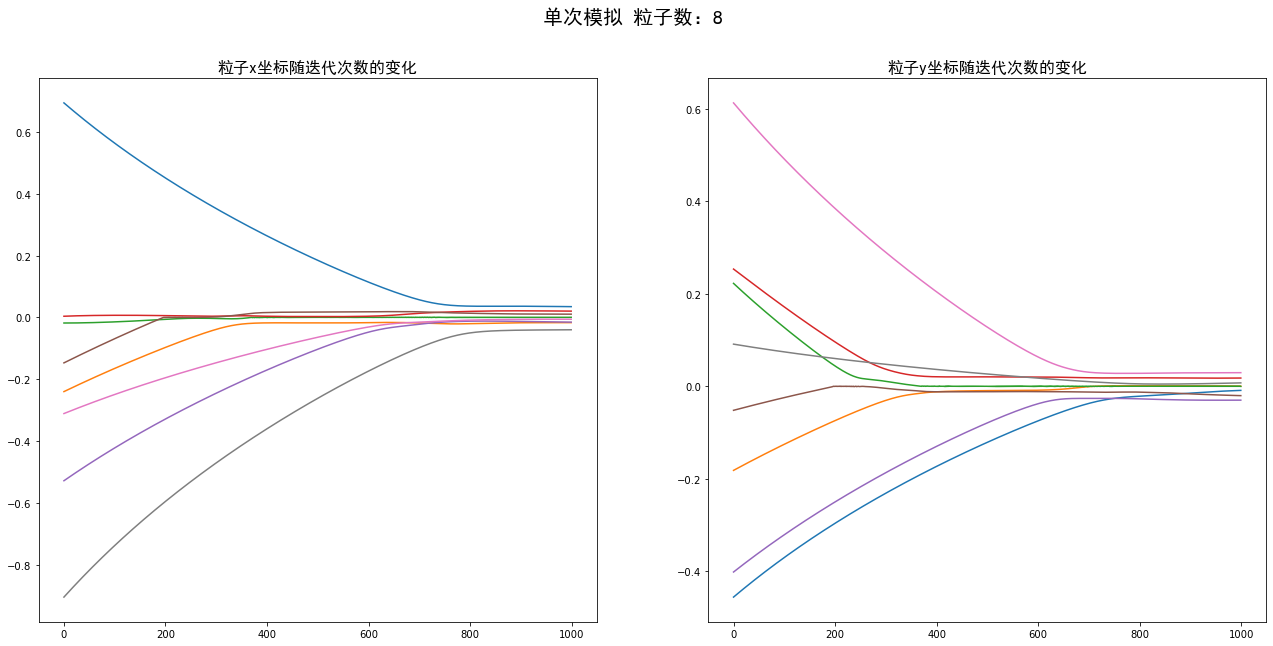

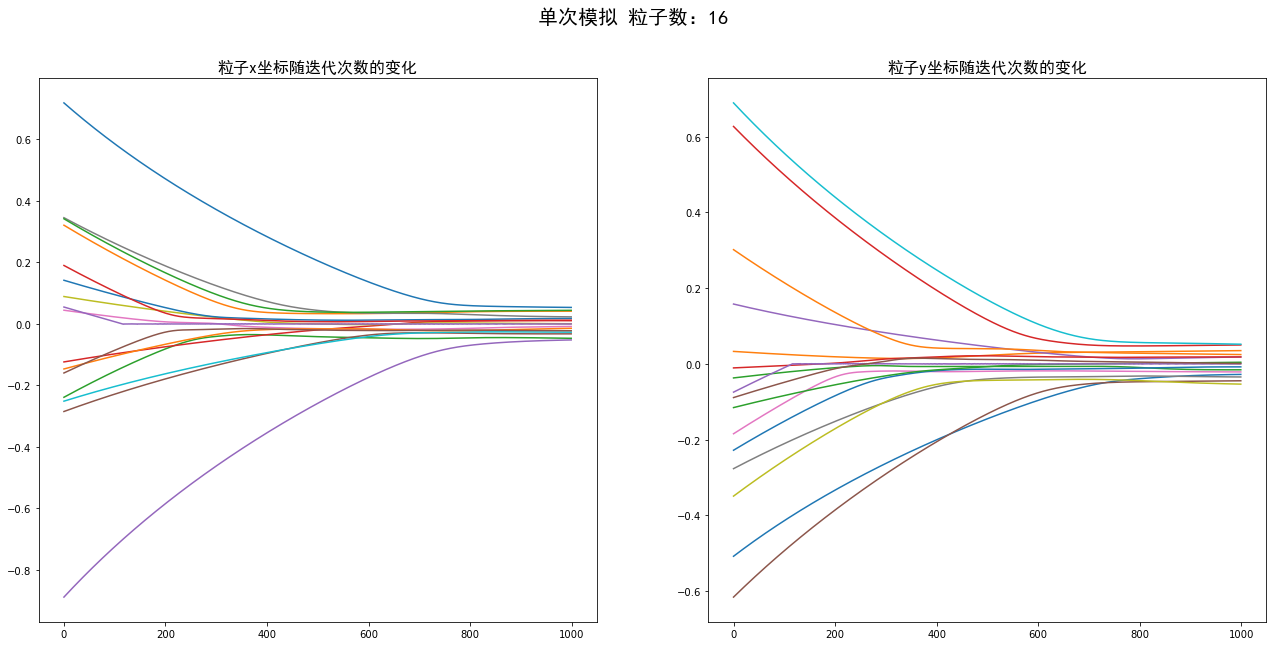

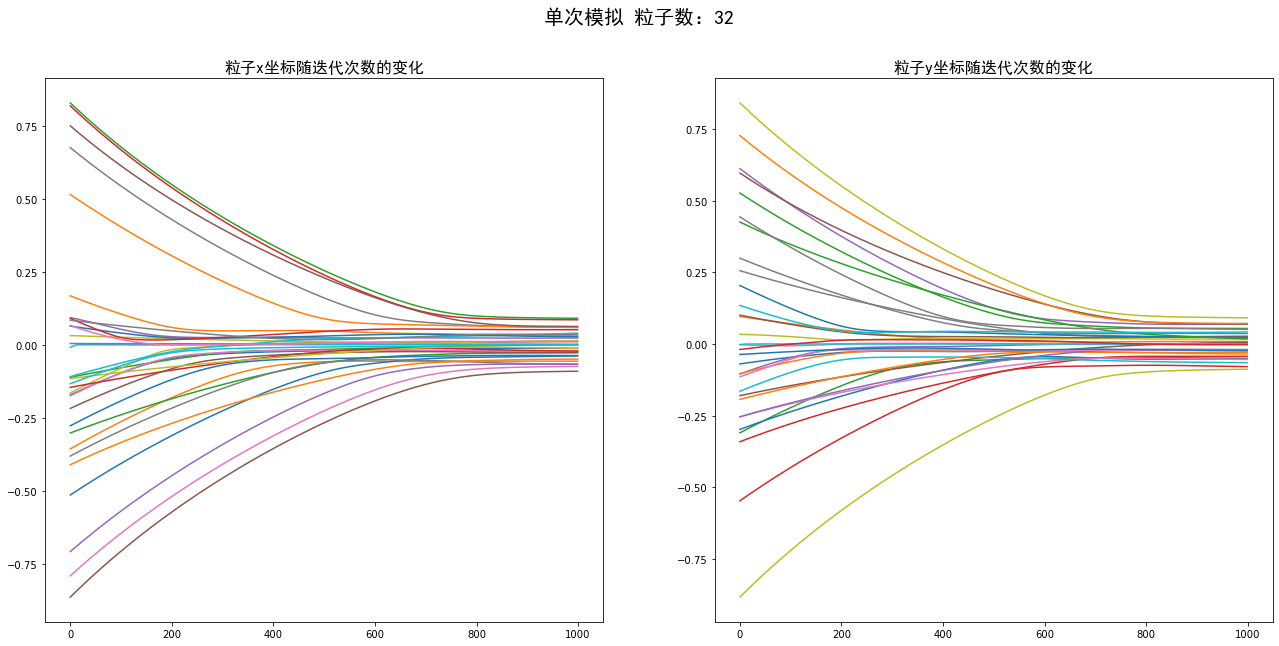

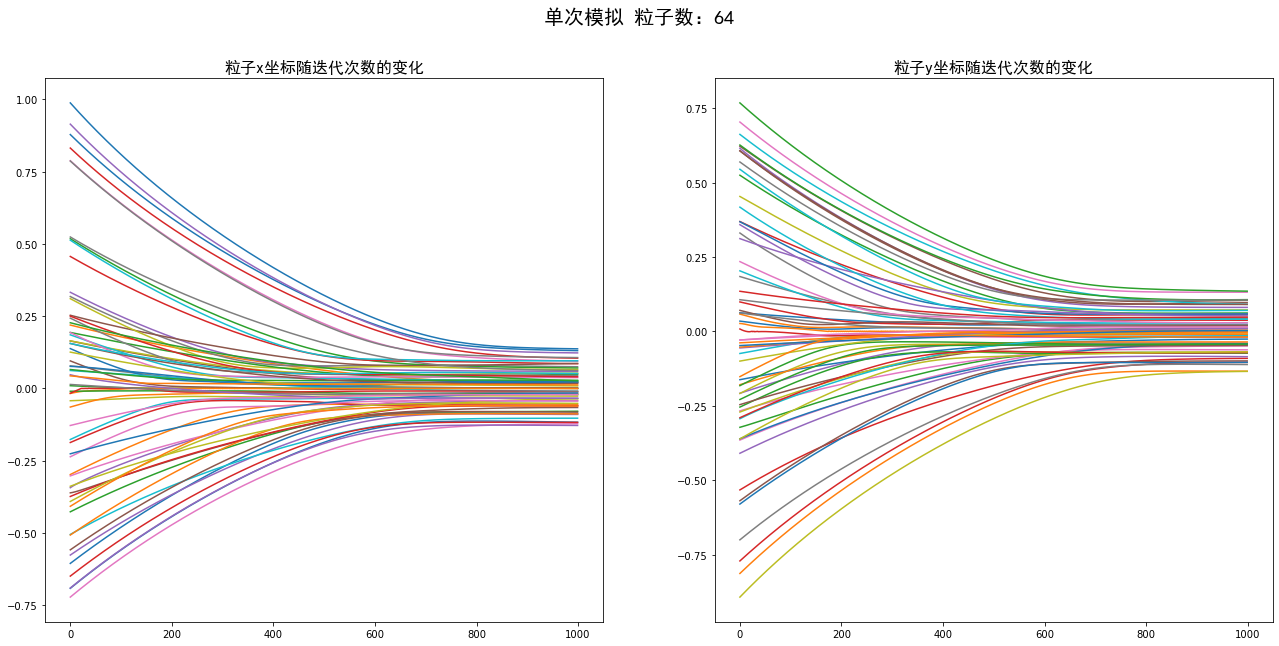

In [37]:
# x坐标随迭代次数的变化
for i, nn in enumerate(nn_list):
    fig=plt.figure(figsize=(22,10))
    fig.suptitle("单次模拟 粒子数：{}".format(nn), fontproperties="SimHei",fontsize=20)

    ax1=fig.add_subplot(121)
    for k in range(nn):
        ax1.plot(np.arange(0,tn,1), array_x[i][0, k, :])
    # ax没有title方法，要用set_title
    ax1.set_title("粒子x坐标随迭代次数的变化", fontproperties="SimHei", fontsize=16)
    
    ax2=fig.add_subplot(122)
    for k in range(nn):
        ax2.plot(np.arange(0,tn,1), array_y[i][0, k, :])
    # ax没有title方法，要用set_title
    ax2.set_title("粒子y坐标随迭代次数的变化", fontproperties="SimHei", fontsize=16)

    plt.show()

可见，900次迭代以后，基本粒子位置基本稳定